# Notebook 3 of 6 - Analysis on Training Set
**Author:** Alexandru Mihalache 

**Date:** November 2022


In [47]:
import pandas as pd
import numpy as np

#Plotting libs
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


#Football libs
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
from mplsoccer import Pitch, Sbopen, VerticalPitch
import socceraction.spadl as spadl
import matplotsoccer as mps
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
from socceraction.vaep import VAEP
SBL = StatsBombLoader()

# utils
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm 
import load_data

from scipy import stats

In [4]:
# load data
# longer run time - this will go over the internet to fetch the files from an S3 bucket
xt, xt_test, vaep, vaep_test, games, games_test, players, players_test, target_players = load_data.load_data('s3')

# VAEP and xT Analysis 

Step 1: Group and aggregate the values per pitch zone and action type.

In [5]:
xt_zone_values = xt[['end_pitch_zone', 'xT_value']].groupby('end_pitch_zone').mean().reset_index()
vaep_zone_values = vaep[['end_pitch_zone', 'vaep_value']].groupby('end_pitch_zone').mean().reset_index()
zone_values = pd.concat([vaep_zone_values, xt_zone_values['xT_value']], axis=1)
action_vaep = vaep[['type_name', 'vaep_value']].groupby('type_name').mean().reset_index()
action_vaep['vaep_sum'] = vaep[['type_name', 'vaep_value']].groupby('type_name').sum().reset_index()['vaep_value']

Step 2: Plot VAEP Sum vs. Mean

Here I distinguish between sum and mean as there is a large imbalance between the different action types. Due to this, when looking at the mean alone, we cant see the overall contribution of each action to a match. 

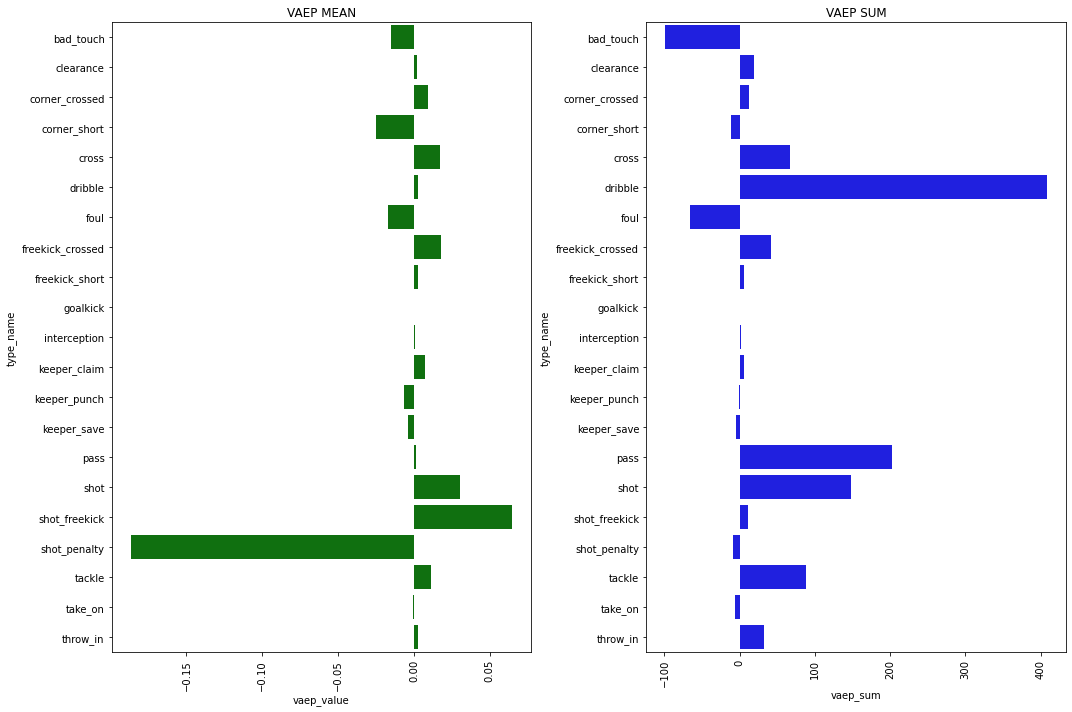

In [39]:
plt.subplots(2,1, figsize=(15,10))

plt.subplot(1,2,1)
sns.barplot(y=action_vaep['type_name'], x=action_vaep['vaep_value'], color='green')
plt.xticks(rotation='90')
plt.title('VAEP MEAN')


plt.subplot(1,2,2)
sns.barplot(y=action_vaep['type_name'], x=action_vaep['vaep_sum'], color='blue')
plt.xticks(rotation='90')
plt.title('VAEP SUM')


plt.tight_layout()
plt.show()

**Observations:**

- Passes and Dribbles are the most common types of actions in a match and as such are the main contributers of overall VAEP
- Mean value of VAEP for dribbles and passes is low, meaning that volume makes up the high contribution from those action types
- Freekicks are highly valuable but very rare, however it does show that having a player that can take advantage of those opportunities, may be an asset to a team
- Similarly crosses are high contributors on average, and are more common, so again having players able to cross the ball well, can create high value chances
- Unexpectedly, penalties are value destroyers - this could be a quirk of the data and how the value is computed on a sequence of events - however at this stage can not determine the root cause. It's feasible to say that after a penalty the game resets, therefore the following actions are lower in VAEP which reflects back on the value of the penalty. Or it could be that those are missed penalties.
- We can also clearly see the actions that destroy VEAP the most, such as Short Corners, Bad Touches, Fouls and Keeper punches. Some of these are expected, however with short corners less so, and this points out a possible tactical tweak that could be exploited by teams, by avoiding short corners and going for a longer cross type corner, which has a positive contribution.

### VAEP Contribution in the run up to a goal

In [40]:
# find goals
vaep[(vaep['type_name']=='shot') & (vaep['result_name']=='success')].head(10)

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,n-5_start_y,n-5_end_x,n-5_end_y,n-5_type_name,n-5_type_name_encoded,n-5_result_name,n-5_bodypart_name,n-5_offensive_value,n-5_defensive_value,n-5_vaep_value
138,7298,3f0fc8e9-a09f-480a-9396-132e1ca05ec5,1,346.0,971,4642.0,94.411765,41.316456,105.000000,31.675949,...,24.962025,97.058824,39.594937,dribble,dribble,success,foot,0.209901,0.000303,0.210204
523,7298,13933d30-56e3-4900-b942-0ee01af8ed1f,1,1401.0,971,4647.0,94.411765,37.873418,105.000000,31.331646,...,20.658228,82.941176,30.987342,pass,pass,success,foot,-0.032877,0.000248,-0.032628
1199,7298,3279e6e0-c796-4871-aaaa-75344dc903b8,2,221.0,746,4654.0,100.588235,33.569620,105.000000,33.827848,...,64.556962,60.000000,57.670886,pass,pass,success,foot,0.002269,0.000859,0.003128
1977,7298,12092a46-bc36-4f00-91f6-767ef8601ae1,2,2434.0,746,4643.0,85.588235,29.265823,105.000000,31.159494,...,32.708861,90.882353,19.797468,pass,pass,success,foot,0.010533,0.000687,0.011221
2458,19778,d78b5024-c498-48f3-8979-b72e575ac84b,1,709.0,746,4643.0,102.352941,43.037975,105.000000,30.987342,...,19.797468,3.529412,20.658228,dribble,dribble,success,foot,0.000000,-0.001170,-0.001170
5565,19771,f4d2311a-c176-4761-8e13-5cc626fb490f,2,291.0,969,15562.0,97.058824,42.177215,104.117647,31.331646,...,38.734177,55.588235,38.734177,dribble,dribble,success,foot,-0.001791,0.000755,-0.001036
6465,19771,efa573c6-1cca-4c51-8e46-f848fa1b5c72,2,2852.0,970,15716.0,98.823529,34.430380,105.000000,32.020253,...,20.658228,87.352941,18.075949,dribble,dribble,success,foot,0.004155,-0.000197,0.003958
7330,19736,f31721b3-2495-4f8b-aa4d-948889c5dfe7,1,2225.0,968,15623.0,90.882353,39.594937,104.117647,35.893671,...,41.316456,53.823529,50.784810,pass,pass,success,foot,0.005099,0.001725,0.006823
7601,19736,06aa93ad-015e-4cac-ae32-745276b4d5cf,2,389.0,968,10192.0,91.764706,9.468354,105.000000,37.701266,...,65.417722,37.941176,65.417722,tackle,other,success,foot,0.002563,0.008858,0.011421
7692,19736,e78e001b-34e4-49d4-bf41-ae8f83a13b95,2,695.0,968,15623.0,98.823529,37.012658,104.117647,30.987342,...,36.151899,100.588235,36.496203,shot,other,fail,foot,-0.256864,-0.000275,-0.257139


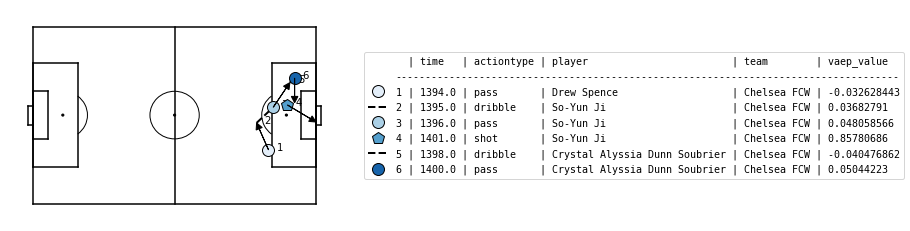

In [22]:
game_id = 7298
df_teams = SBL.teams(game_id)
df_players = SBL.players(game_id)
df_events = SBL.events(game_id)
# Select relevant actions leading up to a goal
df_actions_goal = vaep.loc[523-5: 523]
# # Replace result, actiontype and bodypart IDs by their corresponding name
# df_actions_goal = spadl.add_names(df_actions_goal)
# Add team and player names
df_actions_goal = df_actions_goal.merge(df_teams).merge(df_players)
# Create the plot
mps.actions(
    location=df_actions_goal[["start_x", "start_y", "end_x", "end_y"]],
    action_type=df_actions_goal.type_name,
    team=df_actions_goal.team_name,
    result=df_actions_goal.result_name == "success",
    label=df_actions_goal[["time_seconds", "type_name", "player_name", "team_name", "vaep_value"]],
    labeltitle=["time", "actiontype", "player", "team", "vaep_value"],
    zoom=False
)

**Observations:**

- First pass is actually negative value, likely due to it being slightly backwards
- what we can also see is that VAEP increases as you approach the center of the goal, and that shooting from this position is a big value creator - which would be expected

## End Zone and xT

In [43]:
# group and aggregate by end zone
zone_values = pd.concat([zone_values, vaep.groupby('end_pitch_zone').describe()['x_dif'].reset_index().drop(columns=['end_pitch_zone'])], axis=1)

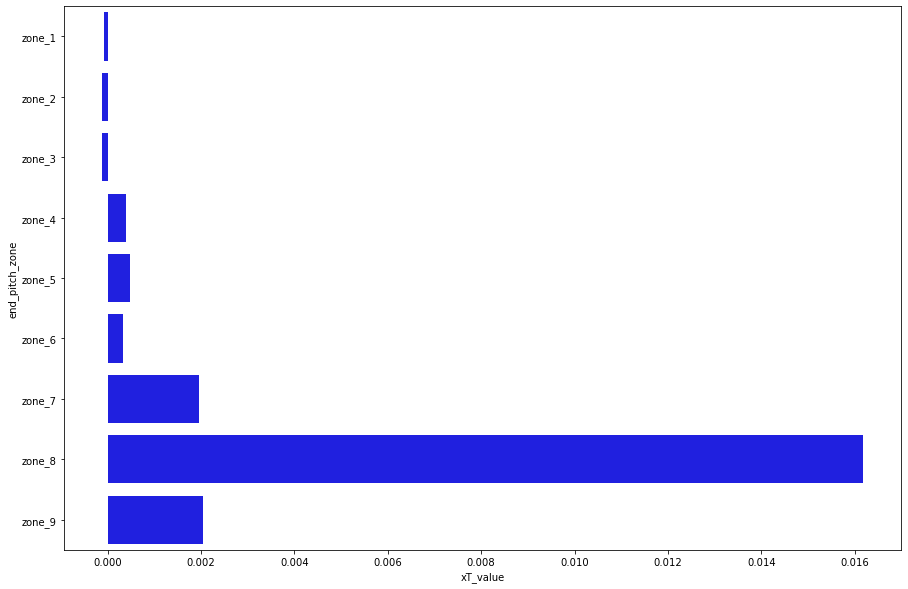

In [44]:
plt.figure(figsize=(15,10))
sns.barplot(y=zone_values['end_pitch_zone'], x=zone_values['xT_value'], color='blue')
plt.show()

#### Observations on xT Value and Pitch Zone

- Zone 8 has the largest mean xT score, which is to be expected as this is where the goal is and therefore it's likely to have more shots and goals from those positions 
- Zones 7 & 9 are the flanks around zone 8 therefore crosses and dangerous passes will come from and into those zones then leading to shots
    - this lines up with our obeservations that crosses are big value creators and therefore the zones crosses are most likely to come from are seeing a large 

## Exploring horizontal direction and VAEP value

So far we've discovered a hypothesis that backward actions are going to destroy value when measured as VAEP. So looking at at the x_dif value plotted against vaep can we see this relationship. 

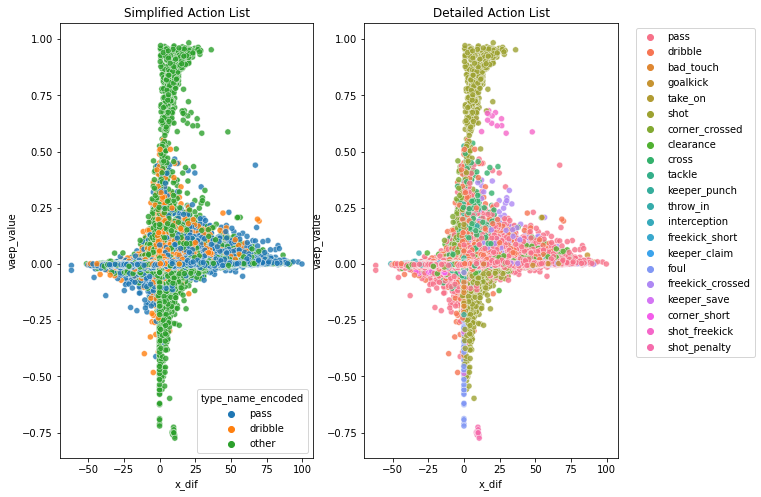

In [41]:
plt.subplots(1,2, figsize=(10,8))
plt.subplot(1,2,1)
sns.scatterplot(data=vaep, x='x_dif', y='vaep_value', hue='type_name_encoded', alpha=0.8)
plt.title('Simplified Action List')
plt.subplot(1,2,2)
sns.scatterplot(data=vaep, x='x_dif', y='vaep_value', hue='type_name', alpha=0.8)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Detailed Action List')
plt.show()

**Observations:**

- We see more dots over the 0 line in the positive ```x-dif``` range, meaning most actions are forward, as expected since both teams want to get closer to the opposition goal and away from their own
- Shots tend to be short and high value, again we'd expect to see this
- We can not conclusively say that backward actions destroy value, as we can also see a significant cluster, mostly shots, being positive and destrying value, as they are likely to have been misses.

- Next will explore if distance and direction show any relationship with whether a move is successful or not.

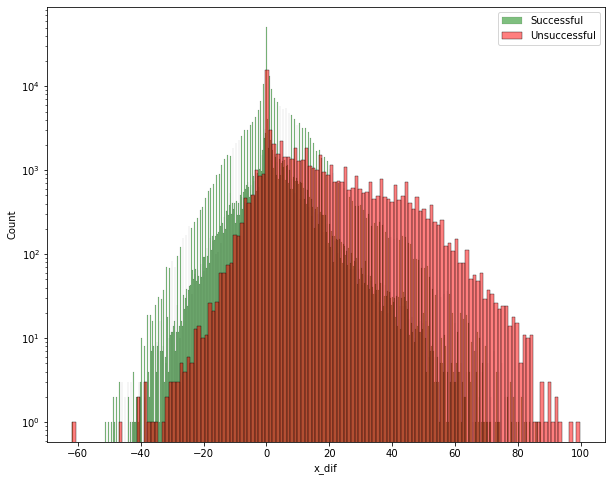

In [56]:
plt.figure(figsize=(10,8))
sns.histplot(vaep[vaep['result_name'] == 'success']['x_dif'], alpha=0.5, color='green', label='Successful')
sns.histplot(vaep[vaep['result_name'] != 'success']['x_dif'], alpha=0.5, color='red', label = 'Unsuccessful')

plt.yscale('log')
plt.legend()
plt.show()

#### Observations on successful moves and their length and direction

- Successful moves are shorter and backwards with a greater frequency
- Unsuccessful moves tend to be longer and with a forward direction - likely due to the riskier nature of those moves
- This would imply that forward moves, should destry more vaep since they're more likely to end in a negative state. However we can see that when looking at VAEP this is not the case, since a forward move, can be part of a goal or shot sequence which are the highest value outcomes, which then gets reflected back down the chain that led to them **(underlying implementation for VAEP and xT use Markov Chains which will distribute some of the final value back to the contributing actions)**

## Detailed look at action types and zones

- Which actions are most likely to get the ball into a specific zone?

In [43]:
# Create a heatmap for action type and end zone
heatmap_data =vaep[['end_pitch_zone', 'type_name']].value_counts().reset_index()
heatmap_data.rename(columns={0:'count'}, inplace=True)
heatmap_data = heatmap_data.pivot('end_pitch_zone', 'type_name', 'count')

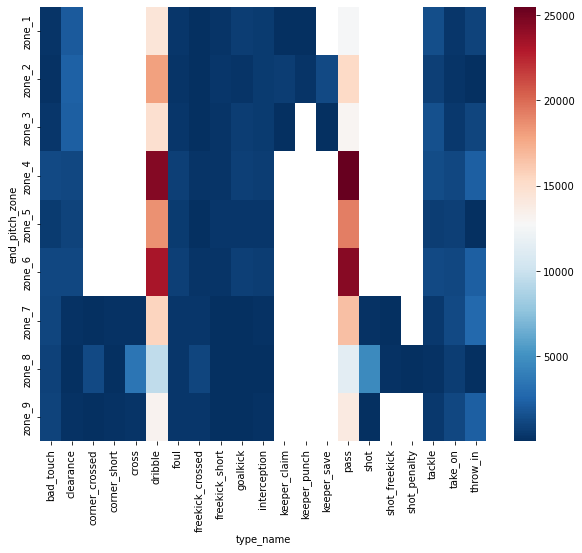

In [49]:
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data, cmap='RdBu_r')
plt.xticks(rotation=90)
plt.show()

**Observations:**

- Dribbles and Passes are highlighted as the key action types in moving the ball
- Zone 6 and Zone 4 are key areas, potentially as a the ball gets moved to the flanks, either in a defensive action to clear the ball or offensively to set up an attack
- Will explore the class imbalances next, as both end zone and action type are in our target variables

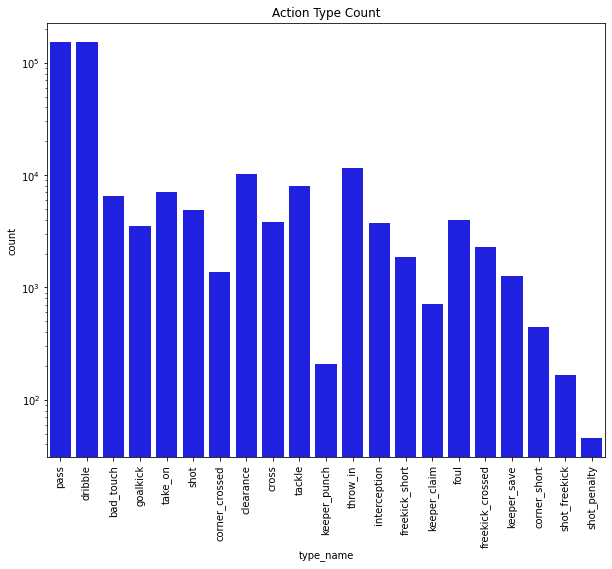

In [51]:
plt.figure(figsize=(10,8))
sns.countplot(vaep['type_name'], color='blue')
plt.xticks(rotation=90)
plt.title('Action Type Count')
plt.yscale('log')
plt.show()

- Passes and Dribbles are significantly more common than the other types
- We'd need to be aware of the class imbalances when modelling 
- Will keep pass and dribbles as they are, but group everything else into a 3rd group

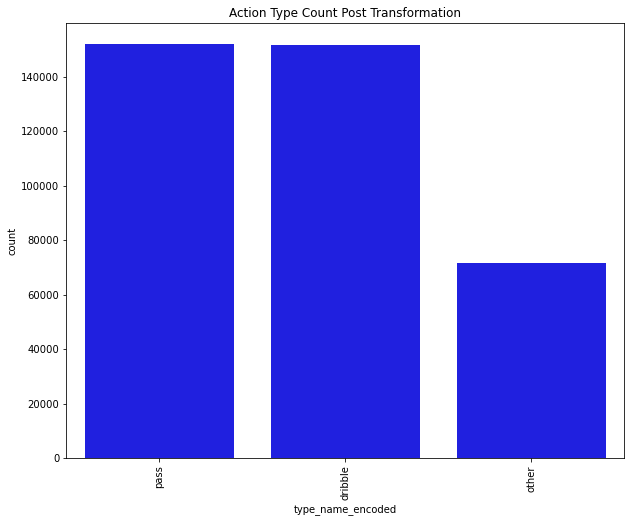

In [54]:
plt.figure(figsize=(10,8))
sns.countplot(vaep['type_name_encoded'], color='blue')
plt.xticks(rotation=90)
plt.title('Action Type Count Post Transformation')
plt.show()

- The other class is still roughly half the size of the main 2, but helps cover some of the gap between the type classes. 
- We want to avoid large class imbalances, as it makes validating the model less accurate. If we left the data as it was, we could predict at random, passes and dribbles and be right most of the time, which is not what we want from the model.

- Next will look at end zones.

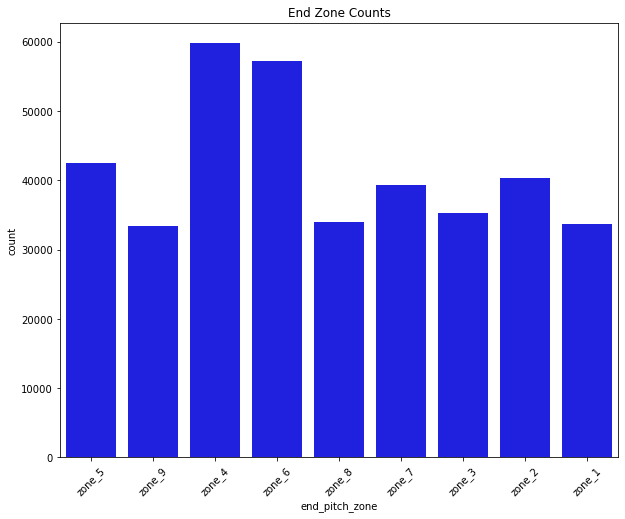

In [55]:
plt.figure(figsize=(10,8))
sns.countplot(vaep['end_pitch_zone'], color='blue')
plt.xticks(rotation=45)
plt.title('End Zone Counts')
plt.show()

**Observations:**

- Zones 4 and 6 are most common, however the difference between classes is not as high as with the action types, therefore will leave the data as is. 
- However this will be important to note when evaluating the models incase we see any bias towards those 2 classes in particular.

## Correlation Analysis 

- We will now look for correlations between the continous target variables and the features I have created
- Will also run a Pearson Correlation statistical test to assess whether they are statistically significant or not

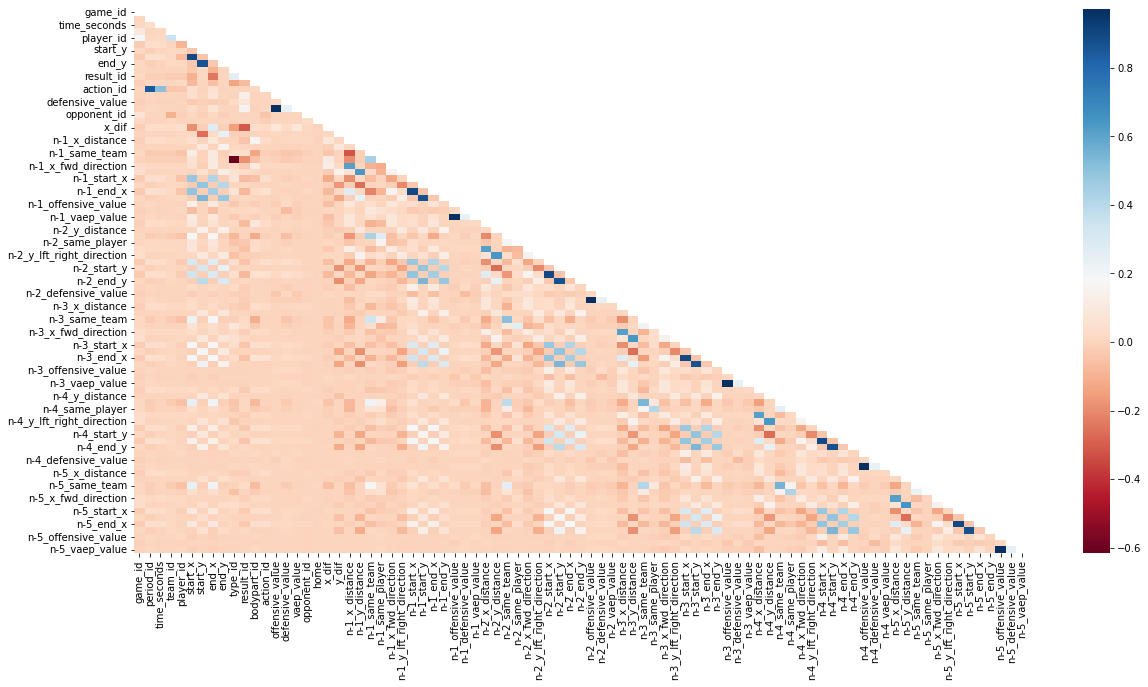

In [57]:
# find the correlation between the variables
corr = vaep.corr()

# plot the correlation matrix using a heatmap
plt.figure(figsize=(20,10))
matrix = np.triu(corr)
sns.heatmap(corr, mask=matrix, cmap='RdBu')
plt.show()

- Due to the number of columns, it's quite difficult to draw conclusions from this graph, however we can see some stronger correlations between the ```n-x``` columns, likely some of the prior moves reflect each other's characteristics in each other - perhaps indicating some multicolinearity. 
- There could perhaps be a risk of data leaking due to this, so the approach to how the data is setup for each model will have to account for this.

**1. VAEP Correlation**

In [62]:
data = []
num_col = vaep.dropna().select_dtypes(include=[np.number])
y_train_vaep = num_col['vaep_value']

for column in num_col.corr().columns:
    data.append(stats.pearsonr(y_train_vaep, num_col[column]))

vaep_corr = pd.DataFrame(data, index=num_col.corr().columns, columns=['Correlation', 'P_value'])

vaep_corr.style.background_gradient(cmap='Oranges')

,Correlation,P_value
game_id,-0.004467,0.006833
period_id,0.005229,0.001545
time_seconds,-0.000062,0.969973
team_id,-0.001895,0.251192
player_id,-0.007008,0.000022
start_x,0.022990,0.000000
start_y,-0.003229,0.050587
end_x,0.062178,0.000000
end_y,-0.000739,0.654734
type_id,-0.002027,0.219718


- We mostly have weak correlations, and in a lot of cases high P_values, indicating that they may not be statistically significant. 
- Will remove the variables with a p_value greater than the 0.005 thereshold to see what we have left

In [70]:
vaep_corr[vaep_corr['P_value']< 0.005].style.background_gradient(cmap='Oranges')

,Correlation,P_value
period_id,0.005229,0.001545
player_id,-0.007008,0.000022
start_x,0.022990,0.000000
end_x,0.062178,0.000000
result_id,0.140597,0.000000
offensive_value,0.972605,0.000000
defensive_value,0.239946,0.000000
vaep_value,1.000000,0.000000
x_dif,0.085411,0.000000
y_dif,0.004938,0.002791


- Offensive and defensive value show the highest correlations - however those are direct components of VAEP and therefore would show this feature. We'd likely have to remove those from our modelling data, to avoid any leaks into the model. 
- Interestingly the prior move VAEP is not highly correlated with the current move, could perhaps indicate some independence between moves.
- Seend that a lot of the zonal/coordinate columns are still considered statistically significant - it could indicate that where the ball starts and ends on the pitch may have greater influence over the value of an action.

**2. xT Correlation**

- will repeat the process to identify features that may be corelated with xT

In [68]:
data_xt = []
num_col_xt = xt.dropna().select_dtypes(include=[np.number])
y_train_xt = num_col_xt['xT_value']

for column in num_col_xt.corr().columns:
    data_xt.append(stats.pearsonr(y_train_xt, num_col_xt[column]))

xt_corr = pd.DataFrame(data_xt, index=num_col_xt.corr().columns, columns=['Correlation', 'P_value'])

xt_corr.style.background_gradient(cmap='Oranges')

,Correlation,P_value
game_id,-0.006685,0.000680
period_id,0.018163,0.000000
time_seconds,0.012815,0.000000
team_id,0.002897,0.140950
player_id,-0.009984,0.000000
start_x,0.119431,0.000000
start_y,-0.009887,0.000001
end_x,0.225689,0.000000
end_y,-0.001192,0.544475
type_id,-0.066574,0.000000


- Removing anything that isn't statistically significant

In [69]:
xt_corr[xt_corr['P_value']< 0.005].style.background_gradient(cmap='Oranges')

,Correlation,P_value
game_id,-0.006685,0.000680
period_id,0.018163,0.000000
time_seconds,0.012815,0.000000
player_id,-0.009984,0.000000
start_x,0.119431,0.000000
start_y,-0.009887,0.000001
end_x,0.225689,0.000000
type_id,-0.066574,0.000000
action_id,0.018272,0.000000
xT_value,1.000000,0.000000


**Observations:**

- End X seems to be the key correlation with xT, so this would be the horizontal location on the pitch - could perhaps be related to higher value areas being closer to the opponents goal. 
- We see that most vairables are similarly correlated with xT as they are with VAEP.